# Analysis of the Combined data for 7pad Scanning

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch, Circle

import numpy as np
from scipy.optimize import minimize

from single_pad_analysis.analysis_functions import *
from single_pad_analysis.HexDetector import HexDetector, hex_radius_inner_to_outer

In [2]:
run_number = 377
basedir_path = 'scan_pad_dfs/'
raw_file_dir = '/media/dn277127/EXTERNAL_USB/2312292/Extras/Physics/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/'
get_pad_csv_path = lambda pool_num, mm_channel: f'{basedir_path}Run{run_number}-Pool{pool_num}-{mm_channel}.csv'

pad_centers_df = pd.read_csv(f'{basedir_path}scan_pad_centers.csv')

In [3]:
class Pad:
    def __init__(self, pool_num, mm_channel, pad_index=0):
        self.pool_num = pool_num
        self.mm_channel = mm_channel
        self.pad_index = pad_index
        self.x_center = None
        self.y_center = None
        self.df = None

    def __repr__(self):
        return f"Pad(pool_num={self.pool_num}, mm_channel={self.mm_channel}, pad_index={self.pad_index}, x_center={self.x_center}, y_center={self.y_center})\n{self.df}"

In [4]:
pads = [  # Need to be careful about the pad index, has to match the HexDetector indexing!
    Pad(4, 'C4', 0),
    Pad(5, 'C2', 1),
    Pad(5, 'C4', 2),
    Pad(3, 'C2', 3),
    Pad(2, 'C4', 4),
    Pad(2, 'C2', 5),
    Pad(4, 'C2', 6)
]

# Need to be careful about the pad index, has to match the pads indexing!
detector = HexDetector(4.3, 29.9, 26.8, np.deg2rad(5.5))
detector.add_pad(0, -1, +1)
detector.add_pad(0, -1, 0)
detector.add_pad(0, -1, -1)
detector.add_pad(0, +1, -1)
detector.add_pad(0, +1, 0)
detector.add_pad(0, +1, +1)

In [5]:
# Update pads with pad center information
for pad in pads:
    pad_center_row = pad_centers_df[(pad_centers_df['run_number'] == run_number) & (pad_centers_df['pool_number'] == pad.pool_num) & (pad_centers_df['channel_number'] == pad.mm_channel)]
    if pad_center_row.empty:
        print(f"Pad center not found for run {run_number}, pool {pad.pool_num}, channel {pad.mm_channel}")
        continue
    elif len(pad_center_row) > 1:
        print(f"Multiple pad centers found for run {run_number}, pool {pad.pool_num}, channel {pad.mm_channel}")
        continue
    pad_center_row = pad_center_row.iloc[0]
    x_center = Measure(pad_center_row['x_center'], pad_center_row['x_center_err'])
    y_center = Measure(pad_center_row['y_center'], pad_center_row['y_center_err'])
    pad.x_center = x_center
    pad.y_center = y_center

In [6]:
# Load dataframes for each pad
for pad in pads:
    pad.df = pd.read_csv(get_pad_csv_path(pad.pool_num, pad.mm_channel))

In [7]:
# Get combined dataframe, concatenating on SRSNo
df_combined = None
for pad in pads:
    cols_rename = {x: f'{x}_{pad.pad_index}' for x in pad.df.columns if x != 'SRSNo'}
    if df_combined is None:
        df_combined = pad.df.rename(columns=cols_rename)
    else:
        df_combined = df_combined.merge(pad.df.rename(columns=cols_rename), on='SRSNo', how='outer')

# Get nan-ignored average of hitX and hitY and eventNo
df_combined['hitX'] = df_combined[[f'hitX_{pad.pad_index}' for pad in pads]].mean(axis=1)
df_combined['hitY'] = df_combined[[f'hitY_{pad.pad_index}' for pad in pads]].mean(axis=1)
df_combined['eventNo'] = df_combined[[f'eventNo_{pad.pad_index}' for pad in pads]].mean(axis=1).astype(int)


In [8]:
# Align hex detector to pad centers
def chi_square(params, pads, detector):
    x_center, y_center, angle = params
    detector.set_rotation(np.deg2rad(angle))
    detector.set_center(x_center, y_center)

    chi2_dx, chi2_dy = 0, 0
    for pad in pads:
        det_x, det_y = detector.get_pad_center(pad.pad_index)
        chi2_dx += ((pad.x_center.val - det_x) / pad.x_center.err)**2
        chi2_dy += ((pad.y_center.val - det_y) / pad.y_center.err)**2

    return np.sum(chi2_dx + chi2_dy)


def fit_hex_detector_to_pad_centers(pads, detector, x0=0, y0=0, angle0=0):
    initial_guess = [x0, y0, angle0]
    bounds = ((0, 100), (0, 100), (-20, 20))  # No bounds on x and y, angle between -180 and 180 degrees
    result = minimize(chi_square, initial_guess, args=(pads, detector), bounds=bounds)
    return result

# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads, detector, x0=29.9, y0=26.8, angle0=5.5)
print(fit_result)
print(fit_result.x)
detector.set_center(fit_result.x[0], fit_result.x[1])
detector.set_rotation(np.deg2rad(fit_result.x[2]))

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3876.4108325926486
        x: [ 2.819e+01  2.655e+01  6.966e-01]
      nit: 7
      jac: [-3.183e-04 -2.274e-04 -9.095e-04]
     nfev: 40
     njev: 10
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[28.19471882 26.55102481  0.69664974]


In [9]:
if os.path.isdir(raw_file_dir):
    plot_single_event(df_combined, 1179, raw_file_dir, run_number, pads, detector)
else:
    print(f'{raw_file_dir} not found, skipping.')

/media/dn277127/EXTERNAL_USB/2312292/Extras/Physics/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ not found, skipping.


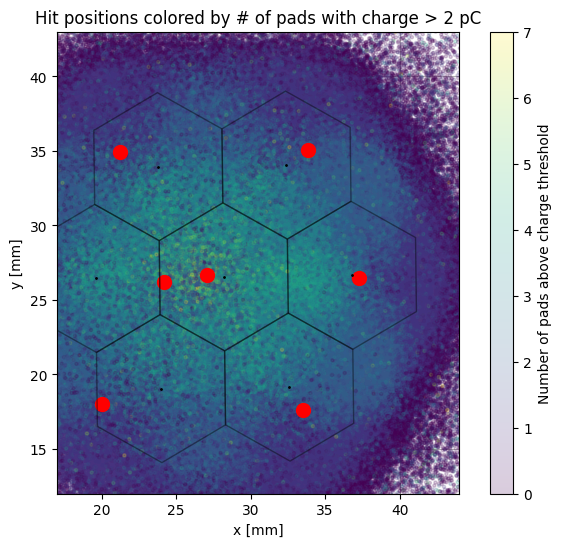

In [10]:
threshold = 2

# Replace NaNs with 0 (or any value below threshold)
totcharge_cols = [f'totcharge_{pad.pad_index}' for pad in pads]
charges = df_combined[totcharge_cols].fillna(0)

# Count how many values in each row are > threshold
charge_count = (charges > threshold).sum(axis=1)

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=charge_count, cmap='viridis', s=5, zorder=2, alpha=0.2)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(17, 44)
ax.set_ylim(12, 43)

for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')

ax.grid(True)
# ax.legend()
ax.set_aspect('equal')

detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.4, pad_colors='none')

In [11]:
# Rotate everything to square up detector
df_combined['hitX'], df_combined['hitY'] = rotate_points(df_combined['hitX'], df_combined['hitY'], -detector.rotation, detector.x, detector.y)
for pad_i in range(len(pads)):
    pads[pad_i].x_center, pads[pad_i].y_center = rotate_points(pads[pad_i].x_center, pads[pad_i].y_center, -detector.rotation, detector.x, detector.y)
detector.set_center(0, 0)
detector.set_rotation(np.deg2rad(0))

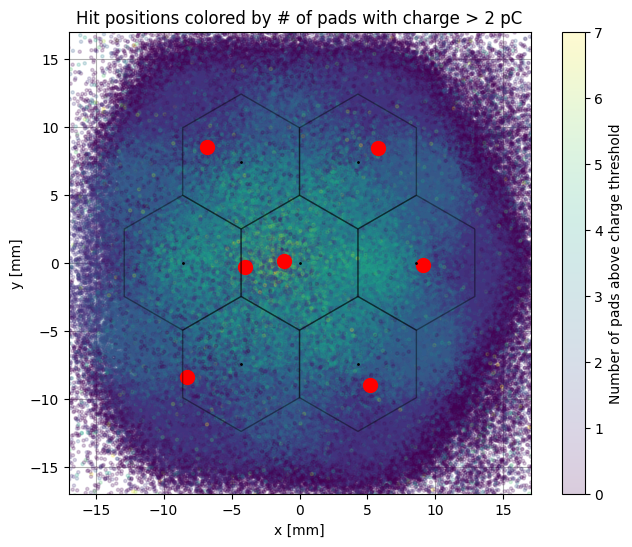

In [12]:
threshold = 2

# Replace NaNs with 0 (or any value below threshold)
totcharge_cols = [f'totcharge_{pad.pad_index}' for pad in pads]
charges = df_combined[totcharge_cols].fillna(0)

# Count how many values in each row are > threshold
charge_count = (charges > threshold).sum(axis=1)

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=charge_count, cmap='viridis', s=5, zorder=2, alpha=0.2)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)

for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')

ax.grid(True)
# ax.legend()
ax.set_aspect('equal')

detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.4, pad_colors='none')

/tmp/ipykernel_976904/561810035.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x_hits, y_hits, cmap='viridis', s=5, zorder=2, alpha=0.5)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

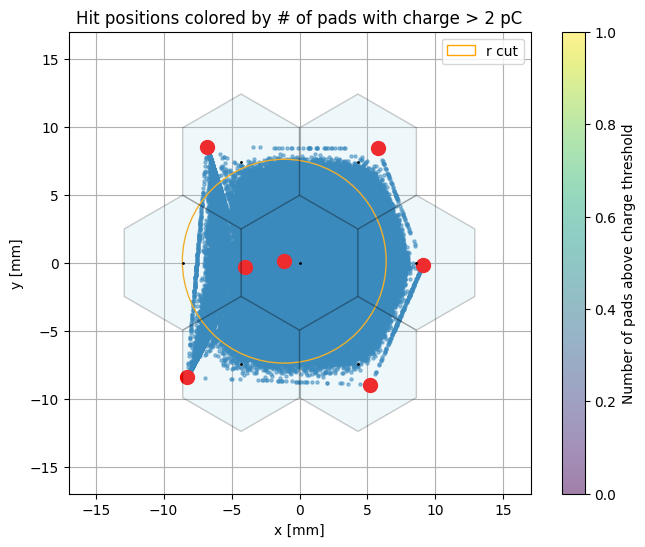

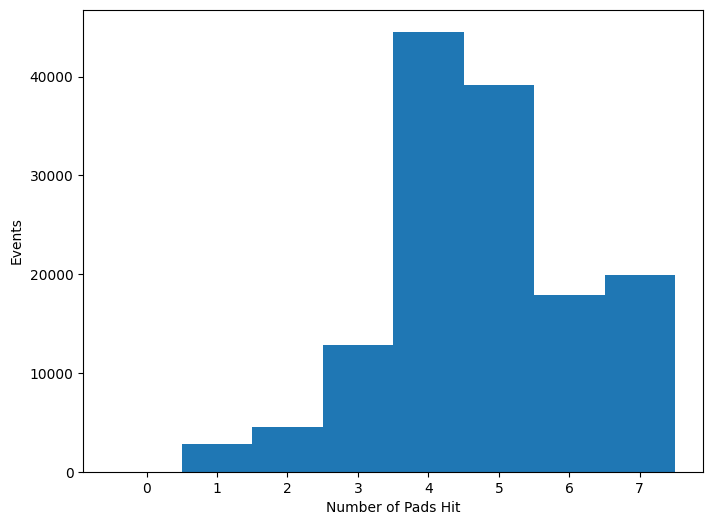

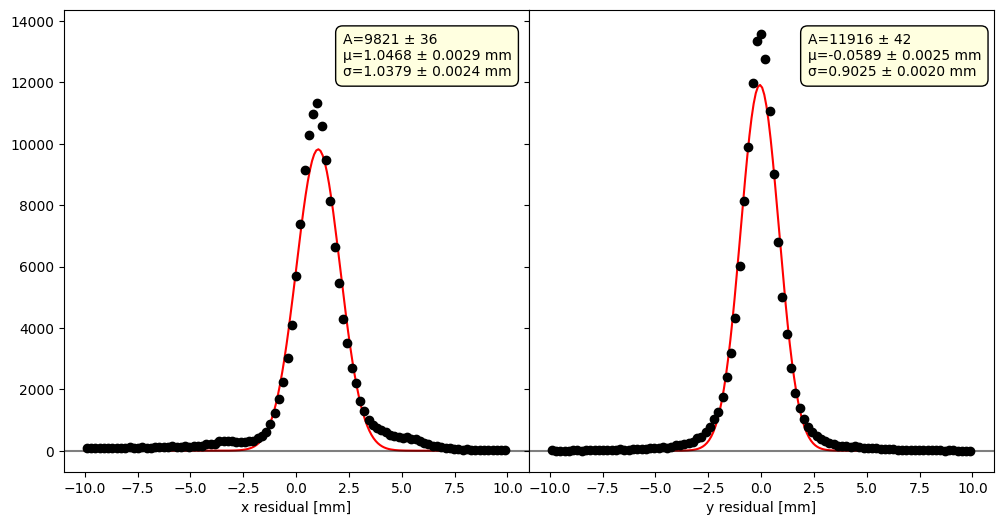

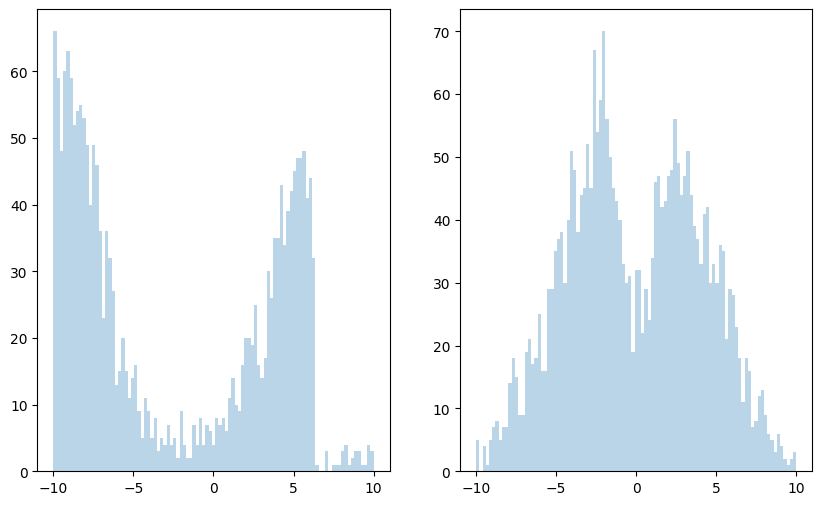

In [13]:
df_combined['r_center'] = np.sqrt((df_combined['hitX'] - detector.x)**2 + (df_combined['hitY'] - detector.y)**2)
r_center_cut = 7.5  # mm, should correspond to centers of surrounding pads
df_filter = df_combined[df_combined['r_center'] < r_center_cut]
x_tracks, y_tracks = df_filter['hitX'], df_filter['hitY']

# Assume pads is a list of Pad objects
weights, x_weighted, y_weighted, n_hits = [], [], [], []

for pad in pads:
    pad_idx = pad.pad_index
    weight = df_filter[f'totcharge_{pad_idx}'].fillna(0)
    weights.append(weight)
    n_hits.append(df_filter[f'totcharge_{pad_idx}'].notna().astype(int))
    x_weighted.append(pad.x_center.val * weight)
    y_weighted.append(pad.y_center.val * weight)

weight_sum = sum(weights)
n_hits = sum(n_hits)
x_hits = sum(x_weighted) / weight_sum
y_hits = sum(y_weighted) / weight_sum

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x_hits, y_hits, cmap='viridis', s=5, zorder=2, alpha=0.5)
circle = Circle((pads[0].x_center.val, pads[0].y_center.val), r_center_cut, color='orange', fill=False, zorder=3, label='r cut')
ax.add_patch(circle)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3)
ax.grid(True)
# ax.legend()
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)
ax.legend()

# Plot n_hits histogram
fig_nhits, ax_nhits = plt.subplots(figsize=(8, 6))
ax_nhits.hist(n_hits, bins=np.arange(0 - 0.5, np.max(n_hits) + 2 - 0.5, 1))
ax_nhits.set_xlabel('Number of Pads Hit')
ax_nhits.set_ylabel('Events')

# Get residuals
x_resids = np.array(x_hits) - np.array(x_tracks)
y_resids = np.array(y_hits) - np.array(y_tracks)

binning = np.linspace(-10, 10, 100)
bin_centers = (binning[1:] + binning[:-1]) / 2

x_resid_hist, x_resid_bin_edges = np.histogram(x_resids, bins=binning)
x_resid_err = np.where(x_resid_hist > 0, np.sqrt(x_resid_hist), 1)
y_resid_hist, y_resid_bin_edges = np.histogram(y_resids, bins=binning)
y_resid_err = np.where(y_resid_hist > 0, np.sqrt(y_resid_hist), 1)

x_resid_popt, x_resid_pcov = cf(gaus, bin_centers, x_resid_hist, p0=[np.max(x_resid_hist), np.mean(x_resids), np.std(x_resids)], sigma=x_resid_err, absolute_sigma=True)
x_resid_meases = [Measure(val, err) for val, err in zip(x_resid_popt, np.sqrt(np.diag(x_resid_pcov)))]
y_resid_popt, y_resid_pcov = cf(gaus, bin_centers, y_resid_hist, p0=[np.max(y_resid_hist), np.mean(y_resids), np.std(y_resids)], sigma=y_resid_err, absolute_sigma=True)
y_resid_meases = [Measure(val, err) for val, err in zip(y_resid_popt, np.sqrt(np.diag(y_resid_pcov)))]

x_plt = np.linspace(binning[0], binning[-1], 200)

fig_resids, ax_resids = plt.subplots(ncols=2, figsize=(12, 6), sharey='all', sharex='all')
ax_resids[0].errorbar(bin_centers, x_resid_hist, yerr=x_resid_err, color='black', fmt='o', ls='none')
ax_resids[1].errorbar(bin_centers, y_resid_hist, yerr=y_resid_err, color='black', fmt='o', ls='none')
ax_resids[0].plot(x_plt, gaus(x_plt, *x_resid_popt), color='red')
ax_resids[1].plot(x_plt, gaus(x_plt, *y_resid_popt), color='red')
ax_resids[0].axhline(0, color='black', alpha=0.5)
ax_resids[1].axhline(0, color='black', alpha=0.5)
ax_resids[0].set_xlabel('x residual [mm]')
ax_resids[1].set_xlabel('y residual [mm]')
x_fit_str = f'A={x_resid_meases[0]}\nμ={x_resid_meases[1]} mm\nσ={x_resid_meases[2]} mm'
ax_resids[0].annotate(x_fit_str, xy=(0.6, 0.95), xycoords='axes fraction', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow'))
y_fit_str = f'A={y_resid_meases[0]}\nμ={y_resid_meases[1]} mm\nσ={y_resid_meases[2]} mm'
ax_resids[1].annotate(y_fit_str, xy=(0.6, 0.95), xycoords='axes fraction', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow'))
fig_resids.subplots_adjust(wspace=0)

fig_resids_nhits, ax_resids_nhits = plt.subplots(ncols=2, figsize=(10, 6))
n_hits_plt, res_x_plt, res_y_plt = [], [], []
for n_hit_i in range(1, max(n_hits) + 1):
    x_hist_i, _, _ = ax_resids_nhits[0].hist(x_resids[n_hits == n_hit_i], bins=binning, label=f'{n_hit_i} Pads Hit', alpha=0.3)
    y_hist_i, _, _ = ax_resids_nhits[1].hist(y_resids[n_hits == n_hit_i], bins=binning, label=f'{n_hit_i} Pads Hit', alpha=0.3)
    popt_x, pcov_x = cf(gaus, bin_centers, x_hist_i, p0=[np.max(x_hist_i), np.mean(x_resids[n_hits == n_hit_i]), np.std(x_resids[n_hits == n_hit_i])])
    pmeas_x = [Measure(val, err) for val, err in zip(popt_x, np.sqrt(np.diag(pcov_x)))]
    popt_y, pcov_y = cf(gaus, bin_centers, y_hist_i, p0=[np.max(y_hist_i), np.mean(y_resids[n_hits == n_hit_i]), np.std(y_resids[n_hits == n_hit_i])])
    pmeas_y = [Measure(val, err) for val, err in zip(popt_y, np.sqrt(np.diag(pcov_y)))]
    n_hits_plt.append(n_hit_i)
    res_x_plt.append(abs(pmeas_x[2]))
    res_y_plt.append(abs(pmeas_y[2]))

ax_resids_nhits[0].legend()
ax_resids_nhits[0].set_xlabel('x residual [mm]')
ax_resids_nhits[1].set_xlabel('y residual [mm]')

fig_resolutions, ax_resolutions = plt.subplots(figsize=(10, 6))
ax_resolutions.errorbar(n_hits_plt, [x.val for x in res_x_plt], yerr=[x.err for x in res_x_plt], label='X Resolution', ls='none', marker='o')
ax_resolutions.errorbar(n_hits_plt, [y.val for y in res_y_plt], yerr=[y.err for y in res_y_plt], label='Y Resolution', ls='none', marker='o')
ax_resolutions.legend()
ax_resolutions.set_ylabel('Resolution [mm]')
ax_resolutions.set_xlabel('Number of Pads Hit')
ax_resolutions.grid(zorder=0)

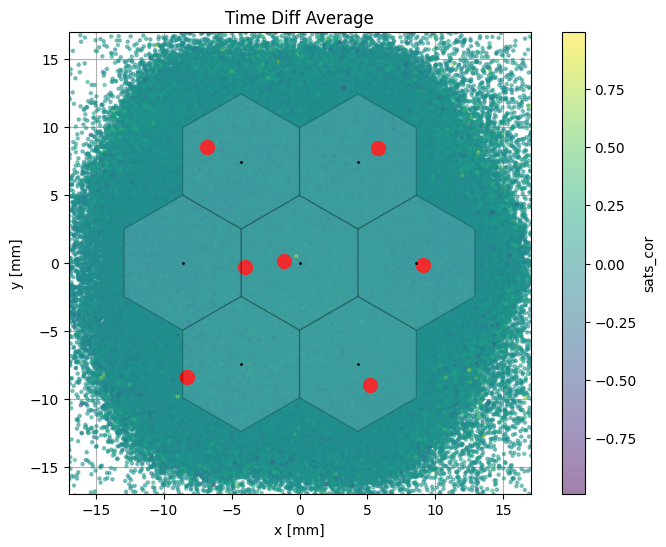

In [14]:
weights, charge_weights, charges, time_diffs_weighted, time_diff_cors_weighted, time_diff_cors_charge_weighted, time_diffs_max, time_diff_cors_max = [], [], [], [], [], [], [], []
for pad in pads:
    pad_idx = pad.pad_index
    weight = (df_combined[f'charge_time_res_{pad_idx}'] ** -2).fillna(0)
    charge_weight = df_combined[f'totcharge_{pad_idx}'].fillna(0)

    weight = np.where(df_combined[f'totcharge_{pad_idx}'] > threshold, weight, 0)
    charge_weight = np.where(df_combined[f'totcharge_{pad_idx}'] > threshold, charge_weight, 0)

    charges = df_combined[f'totcharge_{pad_idx}'].fillna(0)

    time_diff = df_combined[f'time_diff_{pad_idx}'].fillna(0)
    time_diff_cor = df_combined[f'time_diff_cor_{pad_idx}'].fillna(0)
    weights.append(weight)
    charge_weights.append(charge_weight)
    time_diffs_weighted.append(time_diff * weight)
    time_diff_cors_weighted.append(time_diff_cor * weight)
    time_diff_cors_charge_weighted.append(time_diff_cor * charge_weight)
    time_diffs_max.append(time_diff)
    time_diff_cors_max.append(time_diff_cor)

# Calculate the weighted average of time_diff and time_diff_cor
weight_sum = sum(weights)
charge_weight_sum = sum(charge_weights)
time_diff_weighted = sum(time_diffs_weighted) / weight_sum
time_diff_cor_weighted = sum(time_diff_cors_weighted) / weight_sum
time_diff_cor_charge_weighted = sum(time_diff_cors_charge_weighted) / charge_weight_sum

# Build arrays for charges and time_diff_cors
charge_array = np.stack([
    df_combined[f'totcharge_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)  # shape: (n_events, n_pads)

time_diff_array = np.stack([
    df_combined[f'time_diff_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)

time_diff_cor_array = np.stack([
    df_combined[f'time_diff_cor_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)  # shape: (n_events, n_pads)

# For each row (event), get the index of the pad with max charge
max_charge_indices = np.argmax(charge_array, axis=1)  # shape: (n_events,)

# Use advanced indexing to select the time_diff_cor at that index
time_diffs_max = time_diff_array[np.arange(charge_array.shape[0]), max_charge_indices]
time_diff_cors_max = time_diff_cor_array[np.arange(charge_array.shape[0]), max_charge_indices]

time_diff_cor_weighted = np.where((time_diff_cor_weighted < -1) | (time_diff_cor_weighted > 1), np.nan, time_diff_cor_weighted)
time_diff_cor_charge_weighted = np.where((time_diff_cor_charge_weighted < -1) | (time_diff_cor_charge_weighted > 1), np.nan, time_diff_cor_charge_weighted)

# Plot 2D scatter plot of histX_0 and histY_0 with color determined by sats_cor
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=time_diff_cor_weighted, cmap='viridis', s=5, zorder=2, alpha=0.5)
fig.colorbar(scatter, label='sats_cor')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Time Diff Average')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3)
ax.grid(True)
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)

([30.64 ± 0.36], [-2.55 ± 0.43], [5557])

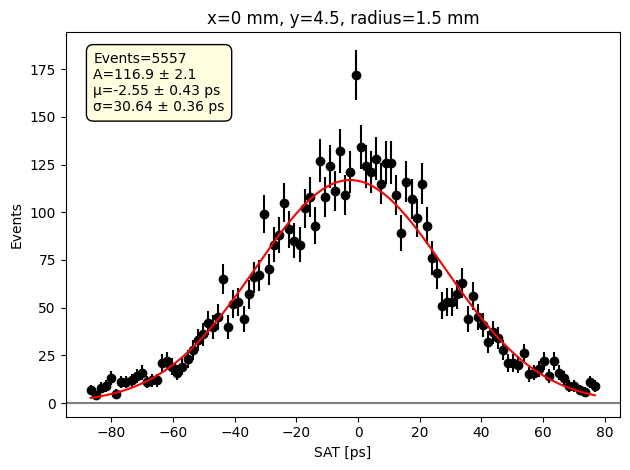

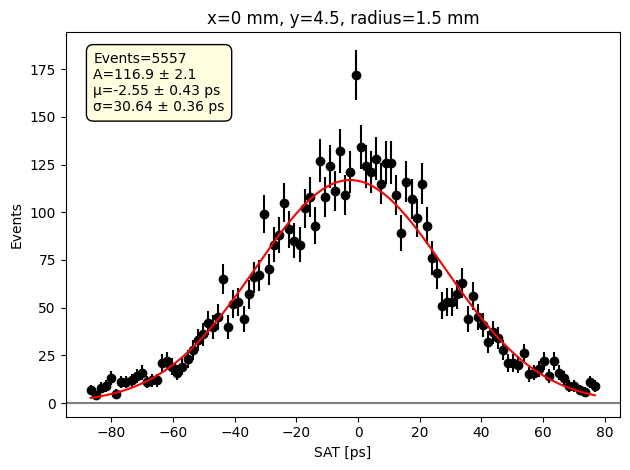

In [15]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (0, 4.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

([29.80 ± 0.36], [10.34 ± 0.44], [5155])

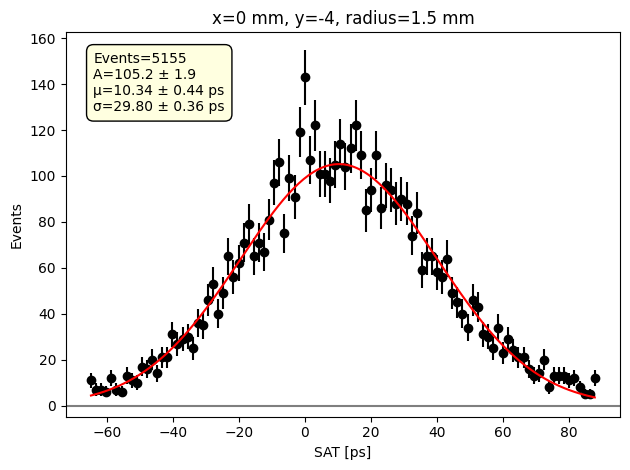

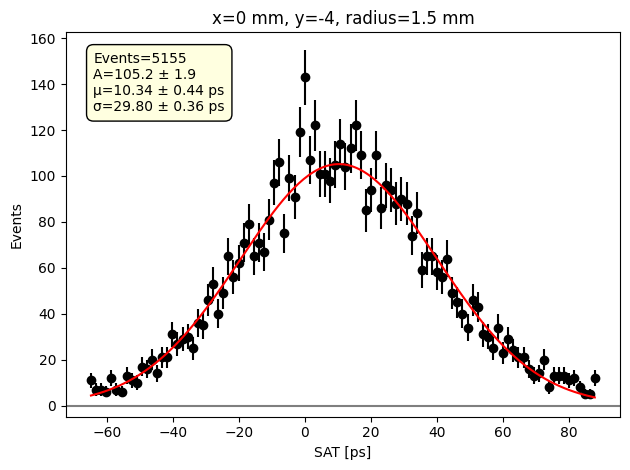

In [16]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (0, -4), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

([30.67 ± 0.36], [-9.54 ± 0.43], [5493])

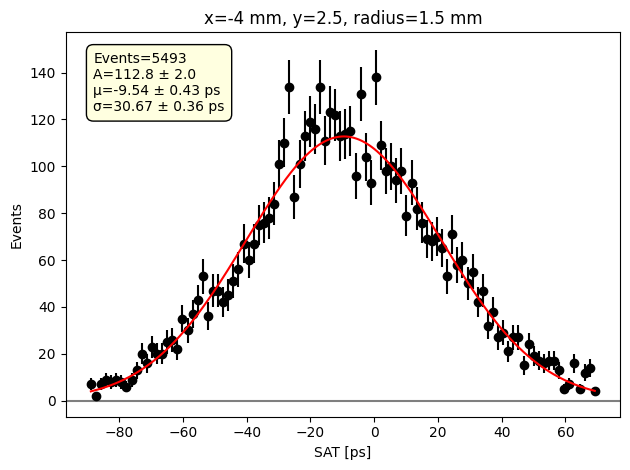

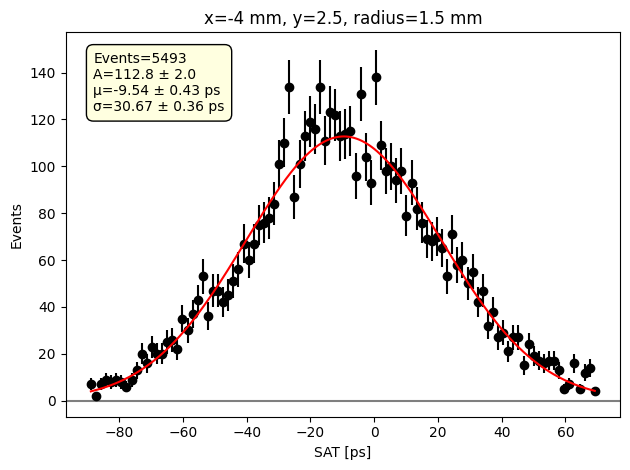

In [17]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (-4, 2.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

([24.91 ± 0.31], [0.29 ± 0.36], [5316])

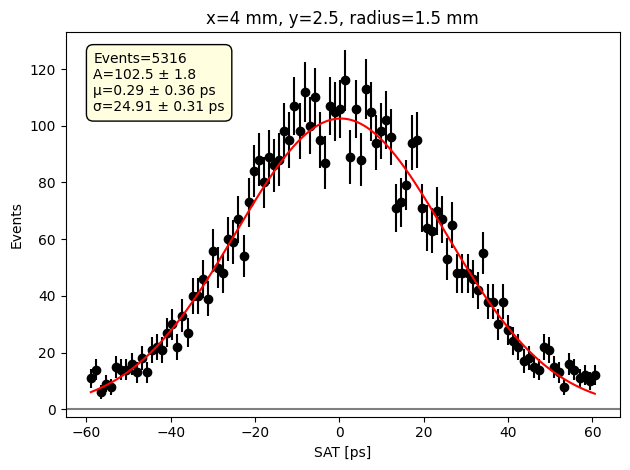

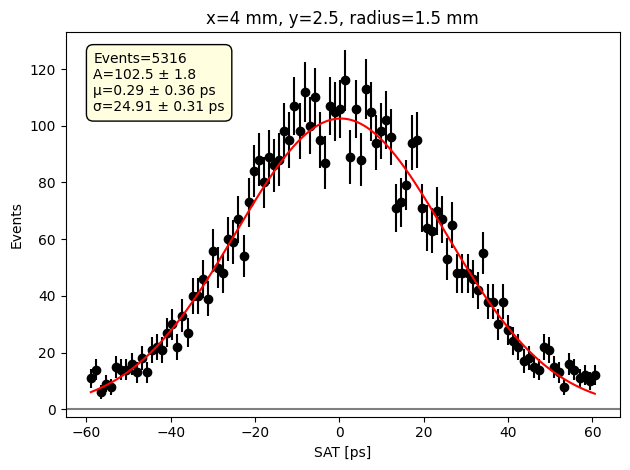

In [18]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (4, 2.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

([30.82 ± 0.37], [5.28 ± 0.43], [5558])

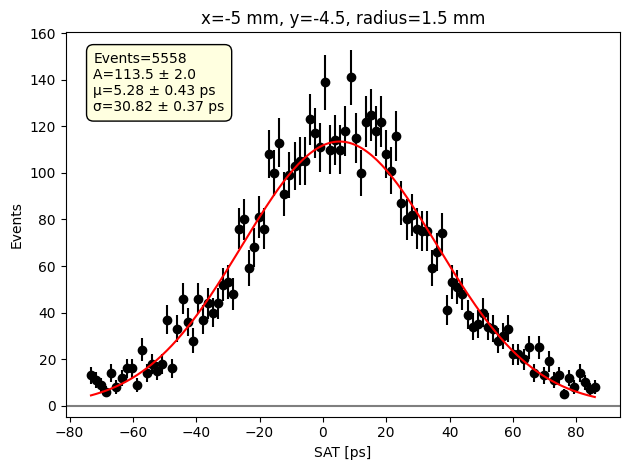

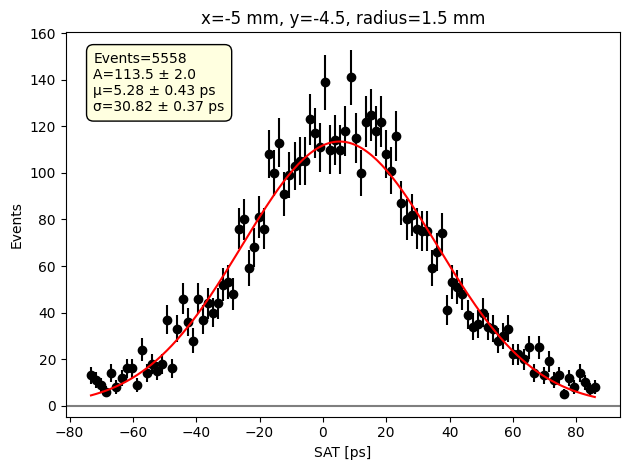

In [19]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (-5, -4.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

([23.56 ± 0.29], [5.23 ± 0.34], [5461])

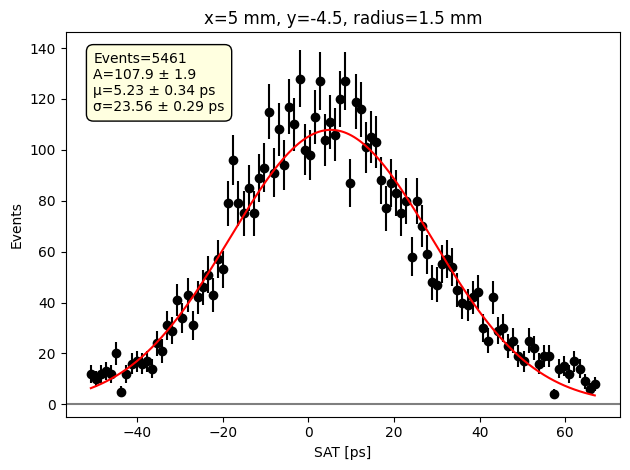

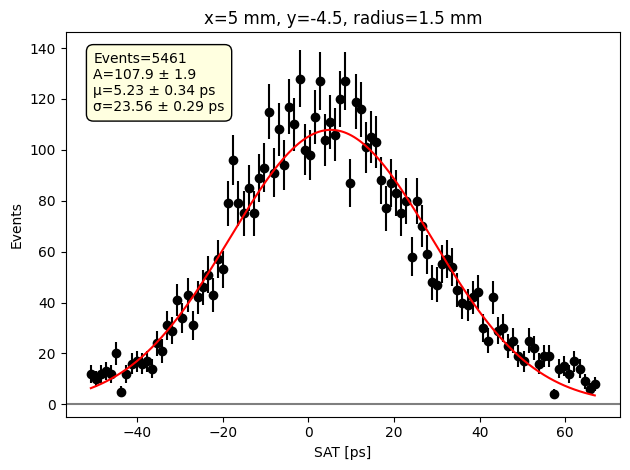

In [20]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (5, -4.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

([30.50 ± 0.34], [-2.42 ± 0.42], [5616])

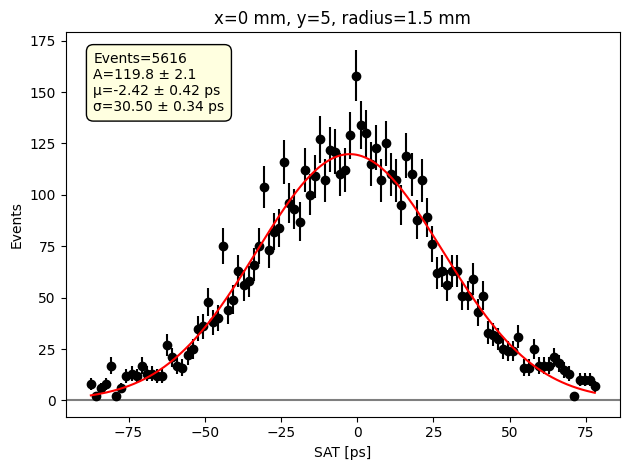

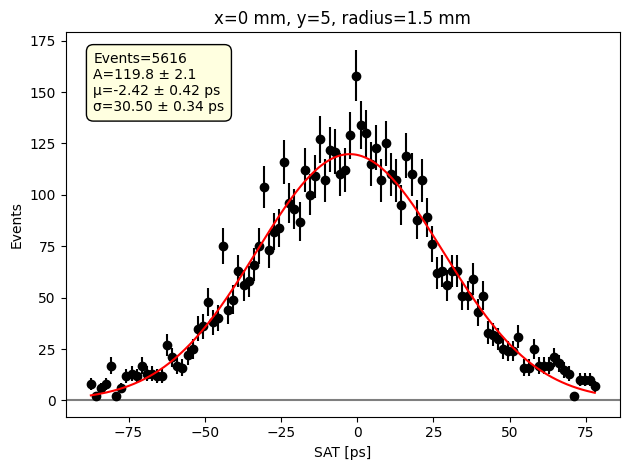

In [21]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (0, 5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

([23.03 ± 0.29], [-7.92 ± 0.33], [5351])

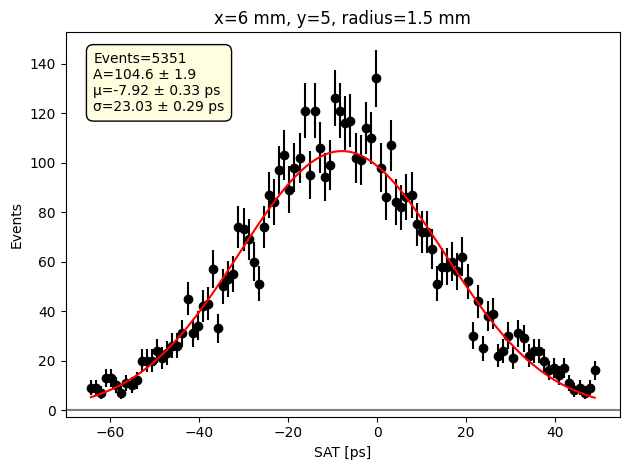

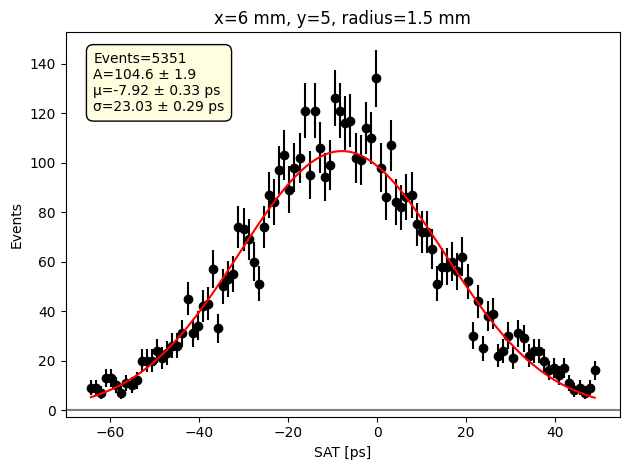

In [22]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (6, 5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
scan_radius = 1.5
min_events_per_circle = 250

n_steps_2D = 150
scan_xs = np.linspace(detector.x - 15, detector.x + 15, n_steps_2D + 1)
scan_ys = np.linspace(detector.y - 15, detector.y + 15, n_steps_2D + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

scan_resolutions, scan_means, events = get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), nsigma_filter=3, plot=False)

plot_2D_circle_scan(scan_resolutions, scan_means, scan_xs, scan_ys, scan_events=events, radius=scan_radius, percentile_filter=[0, 95])

In [ ]:
n_steps = 50
full_scan_radius = 15
fig, axs = plt.subplots(4, 2, figsize=(15, 15), sharey='all', sharex='all')
axs = axs.flatten()
angles = [0, 30, 45, 60, 90, 120, 135, 150]  # degrees
for idx, angle in enumerate(angles):
    ax = axs[idx]
    xy_pairs = generate_line_scan(detector.x, detector.y, full_scan_radius, n_steps, angle)

    # Plot detector with scan line in plot
    inset_ax = inset_axes(ax, width=2, height=2, loc='upper center')
    inset_ax.set_axis_off()
    detector.plot_detector(global_coords=True, ax_in=inset_ax, pad_alpha=0.8)
    # inset_ax.plot([xy[0] for xy in xy_pairs], [xy[1] for xy in xy_pairs], color='red', lw=2)
    inset_ax.scatter([xy[0] for xy in xy_pairs], [xy[1] for xy in xy_pairs], color='red', alpha=0.1, s=130, zorder=11)
    # inset_ax.fill_between([xy[0] for xy in xy_pairs], np.array([xy[1] for xy in xy_pairs]) - scan_radius, np.array([xy[1] for xy in xy_pairs]) + scan_radius, color='red', alpha=0.5)
    arrow = FancyArrowPatch(
        posA=xy_pairs[0],
        posB=xy_pairs[-1],
        arrowstyle='->',          # or '-|>', 'fancy', etc.
        color='red',
        linewidth=2,
        zorder=12,
        mutation_scale=20         # controls arrowhead size
    )

    inset_ax.add_patch(arrow)
    inset_ax.set_aspect('equal')

    for time_diff_cors_i, cor_name in zip([time_diff_cors_max, time_diff_cor_charge_weighted, time_diff_cor_weighted], ['Max Pad', 'Charge Weighted', 'Resolution Weighted']):

        scan_resolutions, scan_means, events = get_circle_scan(
            time_diff_cors_i, df_combined[f'hitX'], df_combined[f'hitY'], xy_pairs,
            radius=scan_radius,
            min_events=min_events_per_circle,
            ns_to_ps=True,
            percentile_cuts=(2, 98),
            plot=False
        )

        # Relative position along the line, in mm
        ts = np.linspace(-scan_radius, scan_radius, len(scan_resolutions))  # line distances
        means = np.array([m.val for m in scan_resolutions])
        errors = np.array([m.err for m in scan_resolutions])

        # ax.errorbar(ts, means, yerr=errors, fmt='o', label=f"{cor_name} {angle}°", alpha=0.8)
        ax.plot(ts, means, alpha=0.5)
        ax.fill_between(ts, means + errors, means - errors, alpha=0.5, label=f'{cor_name}')
        ax.annotate(
            f'{angle}°',
            xy=(0.3, 0.9),  # x, y in axes fraction (0=left/bottom, 1=right/top)
            xycoords='axes fraction', ha='center', va='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"),
            fontsize=18,
            color='black'
        )

    if idx % 2 == 0:
        ax.set_ylabel("Time Resolution (ps)")
    ax.grid(True)
    if idx == 1:
        ax.legend()


axs[-1].set_xlabel("Relative Position along scan line (cm)")
axs[-2].set_xlabel("Relative Position along scan line (cm)")

axs[0].set_ylim(bottom=17, top=54)
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
time_walk_nbins = 50  # For SAT vs charge
n_charge_bins = 50  # For resolution vs charge fits

time_walk_func = time_walk_double_exponential
p0_time_walk = [1.0, -0.1, 0.5, -0.1, 4] #ampl1, decay1, amp2, decay2, bsl

p0_resol = [30, -0.1, 10, -0.05, 20]
resol_func = time_walk_double_exponential
resolution_correction_to_use = 'Corrected Gaus'  # Correction to use moving forward

binning_type = 'equal_stats'
percentile_cut=(2, 98)
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
for pad in pads:
    pad_idx = pad.pad_index
    rs = np.sqrt((df_combined[f'hitX'] - pad.x_center.val)**2 + (df_combined[f'hitY'] - pad.y_center.val)**2)
    df_pad = df_combined[(rs < r_outer) & (np.abs(df_combined[f'time_diff_{pad_idx}']) < 8)]

    time_diffs_i, charges_i = df_pad[f'time_diff_{pad_idx}'], df_pad[f'totcharge_{pad_idx}']
    charges_i, time_diffs_i = filter_sort_charges_time_diffs(time_diffs_i, charges_i)
    fig3, ax3 = plt.subplots()
    ax3.scatter(charges_i, time_diffs_i)
    ax3.set_xlabel('Total Charge[pC]')
    ax3.set_ylabel('SAT [ps]')
    avg_charges, med_time_diffs, std_err_time_diffs, gaus_means, gaus_mean_errs = get_time_walk_binned(time_diffs_i, charges_i, binning_type, time_walk_nbins, percentile_cut)
    ax.errorbar(avg_charges, gaus_means, yerr=gaus_mean_errs, fmt='.', label=f'Pad {pad_idx}')
    ax.set_xlabel('Total Charge[pC]')
    ax.set_ylabel('SAT [ps]')
    ax2.errorbar(avg_charges, np.array(gaus_means) - np.mean(gaus_means), yerr=gaus_mean_errs, fmt='.', alpha=0.5, label=f'Pad {pad_idx}')
    ax2.set_xlabel('Total Charge[pC]')
    ax2.set_ylabel('SAT [ps]')
    if np.max(gaus_mean_errs) > 1000:
        print(f'Pad {pad_idx} is too big -- {np.max(gaus_mean_errs)}')
ax2.legend()


In [ ]:
scan_radius = 1.5
min_events_per_circle = 20

n_steps_2D = 150
scan_xs = np.linspace(detector.x - 15, detector.x + 15, n_steps_2D + 1)
scan_ys = np.linspace(detector.y - 15, detector.y + 15, n_steps_2D + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

hits = ~pd.isna(time_diff_cor_weighted)
efficiencies, eff_events = get_circle_efficiency_scan(hits, df_combined[f'hitX'], df_combined[f'hitY'], xy_pairs, radius=scan_radius, min_events=min_events_per_circle)
plot_2D_efficiency_scan(efficiencies, scan_xs, scan_ys, scan_events=eff_events, radius=scan_radius)